# Multi-layer Perceptron - MNIST Dataset

> MINIST dataset of 28x28 black and white images consisting of handwritten digits, 0 to 9.

<center><img src = "https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1" width="40%"></center>

참고자료
1. https://ariels1996.github.io/deep%20learning/MNIST/
2. https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb

## **1. Import Libaries**

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

### Fixed Random Number Generation

In [62]:
SEED = 1122 

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## **2. Load Data**

In [63]:
from google.colab import drive
drive.mount('/content/drive')

!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [64]:
ROOT = '/temp'
train_data = datasets.MNIST(root=ROOT, train=True, download=True)

Data의 Mean과 Standard Deviation 계산
- Mean 값과 Standard Deviation을 추출하고, 이를 통해 Normalization을 수행
- Normalization은 Training 데이터에만 적용
- 이미지 데이터는 0-255 값을 가지고, 0-1의 데이터 값을 갖기 위해 255로 데이터를 나움

In [65]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


데이터 셋에 Mean 및 Normalization 값을 활용하여 Normalization 수행 
- Torchvision의 transforms() 함수활용
- 추가적으로 transform() 함수를 통해 데이터증가(Augmentation) 수행 
- `RandomRotation` - randomly rotates the image between `(-x, +x)` degrees, where we have set `x = 5`. Note, the `fill=(0,)` is due to a [bug](https://github.com/pytorch/vision/issues/1759) in some versions of torchvision. 
- `RandomCrop` - this first adds `padding` around our image, 2 pixels here, to artificially make it bigger, before taking a random `28x28` square crop of the image.
- `ToTensor()` - this converts the image from a PIL image into a PyTorch tensor.
- `Normalize` - this subtracts the mean and divides by the standard deviations given.

In [66]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])])

정의된 transform을 기준으로 데이터셋 다운로드 및 셋팅

In [95]:
# train_data = datasets.MNIST(root=ROOT,
#                             train=True,
#                             download=True,
#                             transform=train_transforms)

# test_data = datasets.MNIST(root=ROOT,
#                            train=False,
#                            download=True,
#                            transform=test_transforms)

# 데이터를 0과 1사이로 Normalization 
transform = transforms.ToTensor()
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=transform)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=transform)

In [69]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


## **3. Visualize our data**



In [70]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

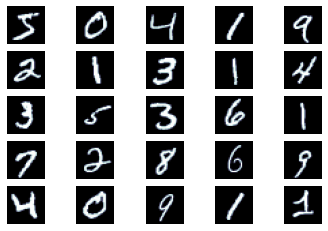

In [71]:
n_images = 25
images = [image for image, label in [train_data[i] for i in range(n_images)]]
plot_images(images)

MINST Training 데이터로부터 Validation 데이터셋 확보
- MINIST Dataset은 Train 및 Test 데이터로 제공
- Training 데이터의 10%를 Validation 데이터로 사용

In [72]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [73]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [74]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


- Validation 데이터는 Training 데이터로부터 추출되었기 때문에 Training 데이터셋에 적용된 Transformation을 형태를 가지고 있음
- Validation 데이터를 Test 데이터와 같은 형태(Transformation이 적용되지 않은 데이터)로 변경

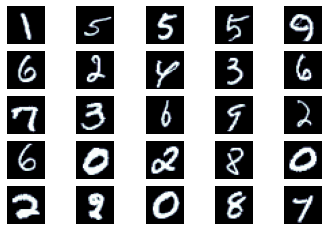

In [75]:
N_IMAGES = 25
images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]
plot_images(images)

Test 데이터셋의 Transformation 형식을 Validation 데이터셋에 적용
- Validation 데에터는 Training 데이터의 Subset이므로, 한 그룹을 변경하면 다른 그룹에도 적용됨
- 따라서, deepcopy()함수를 활용하여 validation과 training의 관계를 끊어버림

In [76]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

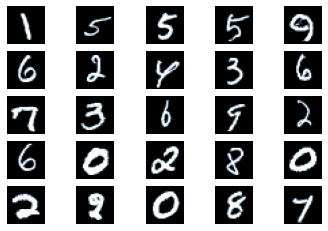

In [77]:
N_IMAGES = 25
images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]
plot_images(images)

## **4. Define DataLoader for our datasets**

In [78]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

(64, 1, 28, 28)


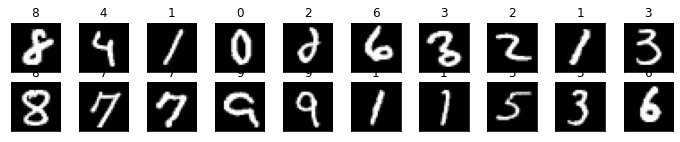

In [100]:
# Obtain one batch of training images
dataiter = iter(train_iterator)

images, labels = dataiter.next()
images = images.numpy()

print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(12, 2))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
 
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

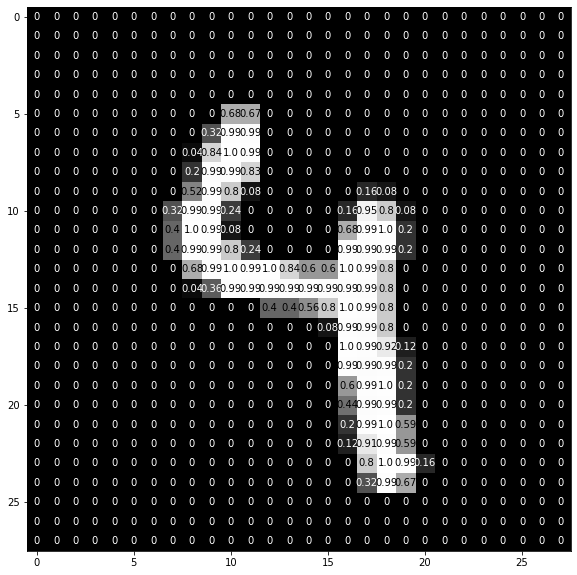

In [102]:
# squeeze를 이용해서 크기가 1인 축을 없애 차원을 축소
img = np.squeeze(images[1])

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

width, height = img.shape

thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        
        # 격자안 색이 thresh 이하일 경우 글자 색은 하얀색
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## **5. Define the Network**

<center><img src = "https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1" width="40%"></center>

- 네트워크 입력으로 이미지(28*28*1)를 784 벡터로 변경
- 첫번째 은닉층은 798 입력 그리고 250 출력을 가지는 레이어
- 두번째 은닉층은 250 입력 그리고 100 출력을 가지는 레이어
- 출력층은 10개의 노드를 가짐(0-9 숫자)

In [80]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred, h_2

In [81]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

학습 파라미터(weights and biases) 수 계산


> $$784 \cdot 250 + 250 + 250 \cdot 100 + 100 + 100 \cdot 10 + 10 = 222,360 $$



In [82]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


## **6. Train the network**

In [83]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

성능측정
- .eq() 함수를 활용하여 모델의 예측 패션 아이템과 레이블이 일치하는지 확인(일치 1, 아니면 0)
- 이후, .sum()을 사용하여 정답인 것들에 대한 합이 구해짐
- view_as() 함수는 target 텐서를 view_as() 함수 안에 들어가는 인수(pred)의 모양대로 다시 정렬


In [84]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

train 함수 정의

In [85]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Eevaluation loop
- put our model into evaluation mode with `model.eval()`
- wrap the iterations inside a `with torch.no_grad()`
- do not zero gradients as we are not calculating any
- do not calculate gradients as we are not updating parameters
- do not take an optimizer step as we are not calculating gradients

In [86]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

1번의 epoch가 수행되는데 걸리는 시간 계산

In [87]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

학습 진행

- 매 학습마다 loss와 accuracy를 계산
- 최고의 validation loss와 accuracy를 보여주는 모델의 파라미터를 저장(state_dict)

In [88]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.299 | Train Acc: 91.65%
	 Val. Loss: 1.321 |  Val. Acc: 84.30%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.118 | Train Acc: 96.46%
	 Val. Loss: 1.771 |  Val. Acc: 84.15%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.077 | Train Acc: 97.62%
	 Val. Loss: 1.773 |  Val. Acc: 86.15%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.057 | Train Acc: 98.25%
	 Val. Loss: 1.354 |  Val. Acc: 90.49%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.043 | Train Acc: 98.71%
	 Val. Loss: 1.443 |  Val. Acc: 90.19%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.032 | Train Acc: 98.94%
	 Val. Loss: 1.885 |  Val. Acc: 88.40%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.026 | Train Acc: 99.19%
	 Val. Loss: 1.641 |  Val. Acc: 90.55%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.020 | Train Acc: 99.37%
	 Val. Loss: 1.524 |  Val. Acc: 91.56%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.017 | Train Acc: 99.41%
	 Val. Loss: 2.185 |  Val. Acc: 89.33%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 6s
	Train Loss: 0.017 | Train Acc: 99.41%
	 Val. Loss: 1.747 |  Val. Acc: 91.82%


최적 모델 불러오기

In [89]:
model.load_state_dict(torch.load('best-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.146 | Test Acc: 95.57%


##  **7. Examine our Model**
- 잘못 예측된 사진에 대한 정보 분석
- 아래 함수는 주어진 데이터로부터 모델 예측을 반환

In [90]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [91]:
images, labels, probs = get_predictions(model, test_iterator, device)

# argmax: tensor로부터 가장 큰 값이 있는 곳의 위치를 반환하는 함수
pred_labels = torch.argmax(probs, 1)

print(probs)
print(pred_labels)
print(labels)

tensor([[6.1176e-06, 5.1800e-07, 4.0081e-04,  ..., 9.9761e-01, 5.5489e-06,
         1.3215e-04],
        [3.4992e-05, 3.3384e-04, 9.8478e-01,  ..., 4.2447e-07, 7.9816e-04,
         2.2548e-09],
        [6.0824e-06, 9.9035e-01, 2.3354e-03,  ..., 4.5250e-03, 7.3723e-04,
         1.6390e-04],
        ...,
        [3.7859e-08, 5.1824e-08, 3.5376e-07,  ..., 1.3176e-04, 2.2891e-04,
         4.6676e-03],
        [2.7706e-05, 2.4280e-06, 8.1244e-08,  ..., 3.5576e-06, 2.0388e-03,
         2.7389e-05],
        [1.2579e-05, 1.3706e-09, 2.0216e-05,  ..., 1.4130e-09, 2.3054e-07,
         9.9917e-08]])
tensor([7, 2, 1,  ..., 4, 5, 6])
tensor([7, 2, 1,  ..., 4, 5, 6])


torch eq() 멤버함수를 활용한 정답을 가진 위치 계산

In [92]:
corrects = torch.eq(labels, pred_labels)
print(corrects)

tensor([True, True, True,  ..., True, True, True])


We can then loop through all of the examples over our model's predictions and store all the examples the model got incorrect into an array.

Then, we sort these incorrect examples by how confident they were, with the most confident being first.

In [93]:
# 잘못 예측된 데이터 추출
incorrect_examples = []
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

잘못 예측된 자료의 가시화

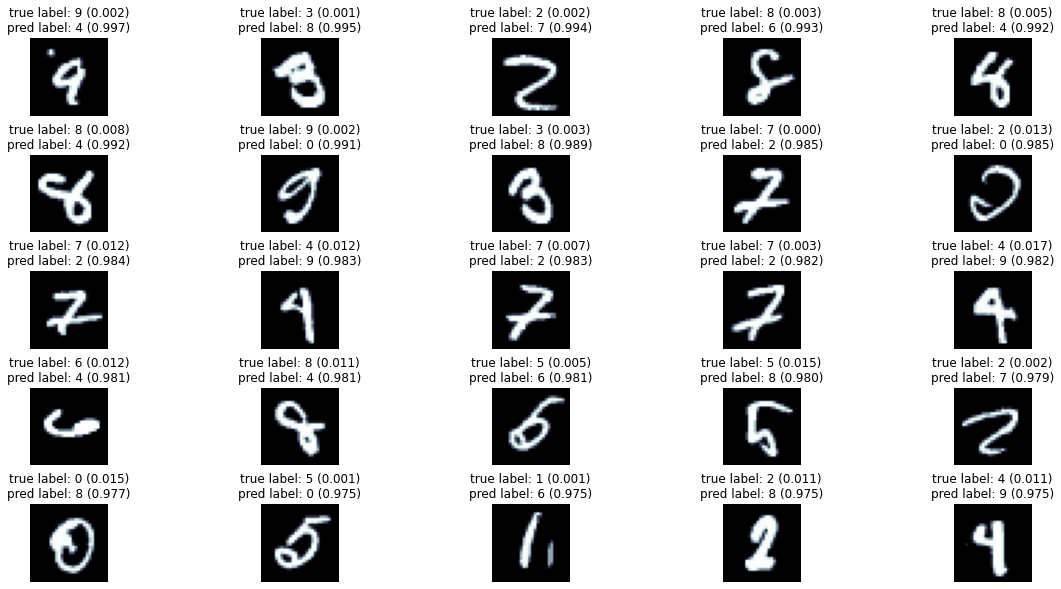

In [94]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)
  
N_IMAGES = 25
plot_most_incorrect(incorrect_examples, N_IMAGES)